In [12]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import gc
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pywt, librosa 
import multiprocessing
from multiprocessing import Pool

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Training on CPU")


Training on GPU: NVIDIA GeForce RTX 3080 Laptop GPU


In [13]:
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from config.constants import *
from viz.plot import *
from features.statistical_features import*
from tracking.save_log import *
from features.process_eeg import*

Seperating into 10s?
4 or 5 channels?
all 19 channals?


hop_length = len(x)//final_length. final_length = 1000? then hop_length= 10, however win_length should be sufficient
Combination of win_length = 256, 512,1024?  n_mels = 16?

Try: Samller hop length + larger win_size?


In [15]:
GENERATE_DATA = True

In [17]:
eeg_montage_path = f"{PROCESSED_DATA_DIR}/eeg_data_dict.pickle"
with open(eeg_montage_path, 'rb') as handle:
    eeg_data_dict = pickle.load(handle)

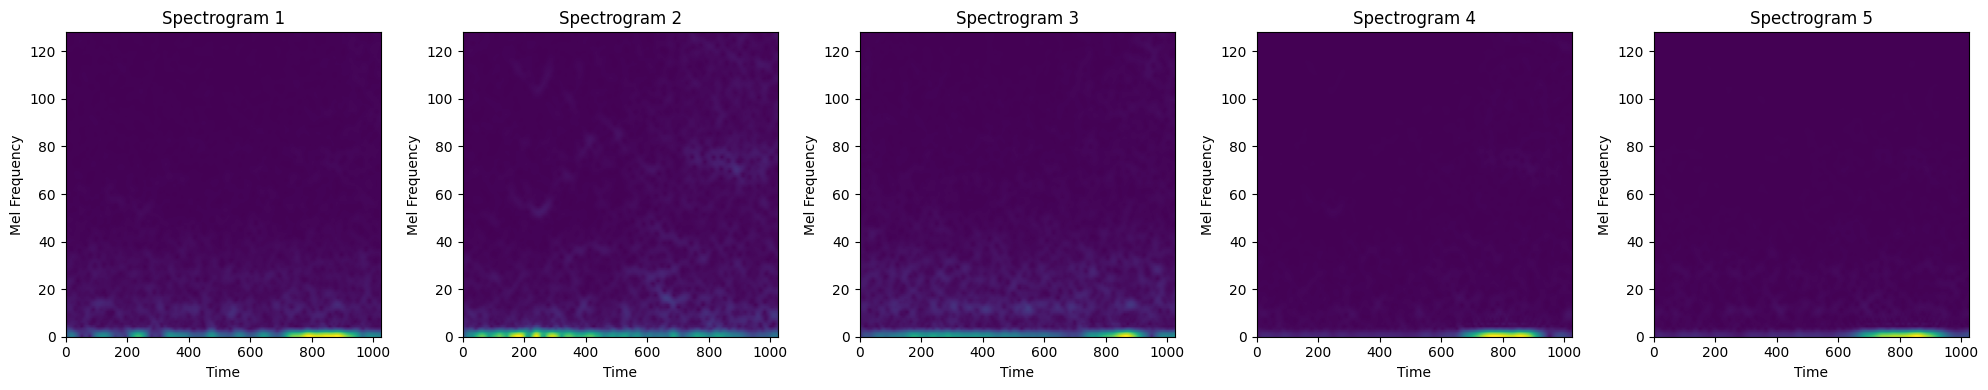

In [18]:
#VISUALIZE 1ST ELEMENT
first_key = list(eeg_data_dict.keys())[0]  # 获取第一个键名
data_to_process = eeg_data_dict[first_key]["data"]

processed_img_stft_sample = spectrogram_from_eeg_stft(data_to_process, spe_width = 1024, n_fft=1024, spe_win = 512, display=True)

In [19]:
np.shape(processed_img_stft_sample)

(128, 1024, 5)

In [20]:
def process_sample(sample_data):
    key, value = sample_data
    data = value['data']
    processed_data = spectrogram_from_eeg_stft(data, spe_width=1024, n_fft=1024, spe_win=256, display=False)
    processed_data = np.nan_to_num(processed_data, nan=0.0)
    
    mn = processed_data.flatten().min()
    mx = processed_data.flatten().max()
    ep = 1e-5
    processed_data = (processed_data - mn) / (mx - mn + ep)
    
    targets = value['targets']
    processed_sample = []
    
    for i in range(processed_data.shape[2]):  # 5 channels
        single_channel_data = processed_data[:, :, i]
        sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)
        processed_sample.append(sampler_result)
    
    flattened_sample = np.concatenate([np.ravel(sample) for sample in processed_sample])
    #return np.concatenate([flattened_sample, targets]), processed_data
    return np.concatenate([flattened_sample, targets])

if GENERATE_DATA:
    processed_sampler_data = []
    #standardized_processed_data = []

    with Pool(processes=4) as pool:
        results = pool.map(process_sample, eeg_data_dict.items())
        for sampler_result in results:
            processed_sampler_data.append(sampler_result)

else:
    spe_sampler_50s_data_dict_path = f"{PROCESSED_DATA_DIR}/spe_sampler_50s_data_dict.pickle"
    with open(spe_sampler_50s_data_dict_path, 'rb') as handle:
        processed_sampler_data = pickle.load(handle)
    print(len(processed_sampler_data))


In [ ]:
# if GENERATE_DATA:
#     processed_sampler_data = []
#     for index, (key, value) in enumerate(eeg_data_dict.items()):
#         data = value['data']
#         #processed_data = spectrogram_from_eeg(data, spe_width=1000, spe_mels=64, spe_win=256, display=False)
#         processed_data = spectrogram_from_eeg_stft( data, spe_width = 1000, n_fft=1024, spe_win = 512, display=False )
        
#         processed_data = np.nan_to_num(processed_data, nan=0.0) 
        
#         mn = processed_data.flatten().min()
#         mx = processed_data.flatten().max()
#         ep = 1e-5
#         processed_data= (processed_data - mn) / (mx - mn + ep)
        
#         targets = value['targets']
        
#         processed_sample = []
        
#         for i in range(processed_data.shape[2]):  # 5 channels
#             single_channel_data = processed_data[:, :, i]
#             sampler_result = SAMPLERrep_ver2(single_channel_data, axis=1)
#             processed_sample.append(sampler_result)
        
#         flattened_sample = np.concatenate([np.ravel(sample) for sample in processed_sample])
#         processed_sampler_data.append(np.concatenate([flattened_sample, targets]))
        
#         if (index + 1) % 500 == 0:
#             print(f"Processed {index + 1} samples.")
    
# else:
#     spe_sampler_50s_data_dict_path = f"{PROCESSED_DATA_DIR}/spe_sampler_50s_data_dict.pickle"
#     with open(spe_sampler_50s_data_dict_path, 'rb') as handle:
#         processed_sampler_data = pickle.load(handle)
#     print(len(processed_sampler_data))


Create Dataset

In [ ]:
SAVE_SATA = True
if SAVE_SATA:
    log_feature_file(log_path =os.path.join(PROCESSED_DATA_DIR, "features_log.csv"), 
                     file_name = "spe_stft_sampler_50s_128*1024*5img.pickle", 
                     file_type = "Pickle", 
                     note = "spectrogram_from_eeg_stft( data, spe_width = 1024, n_fft=1024, spe_win = 512, display=False ),sampler size = 10", 
                     processed_sampler_data = processed_sampler_data, 
                     PROCESSED_DATA_DIR = PROCESSED_DATA_DIR)
    
    log_feature_file(log_path =os.path.join(PROCESSED_DATA_DIR, "features_log.csv"), 
                    file_name = "spe_stft_50s_128*1024*5img.pickle", 
                    file_type = "Pickle", 
                    note = "spectrogram_from_eeg_stft( data, spe_width = 1024, n_fft=1024, spe_win = 512, display=False )", 
                    processed_sampler_data = standardized_processed_data, 
                    PROCESSED_DATA_DIR = PROCESSED_DATA_DIR)

In [ ]:
print(len(processed_sampler_data))
print(len(processed_sampler_data[0]))
print(len(standardized_processed_data))
print(len(standardized_processed_data[0]))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature, label

Create Multinomial LR Model

In [ ]:
class SimpleMultinomialModelKL(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMultinomialModelKL, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x = self.fc(x)
        log_probs = F.log_softmax(x, dim=1)  # log_softmax to fit KL-DIV
        return log_probs

In [ ]:
class EnhancedMultinomialModelKL(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(EnhancedMultinomialModelKL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        log_probs = F.log_softmax(x, dim=1)  # 使用log_softmax适配KL散度
        return log_probs


In [ ]:
class SimpleMultinomialModelKL_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMultinomialModelKL_2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        log_probs = F.log_softmax(x, dim=1)  # log_softmax to fit KL-DIV
        return log_probs


Train

In [ ]:
# def lasso_penalty(model, lambda_lasso):
#     l1_norm = sum(p.abs().sum() for p in model.parameters())
#     return lambda_lasso * l1_norm

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = 0
        # 训练过程
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            #target_log = torch.log(target+1e-8) 
            #loss = criterion(output, target) + lasso_penalty(model, lambda_lasso)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # 计算平均训练损失
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证过程
        model.eval()  # 将模型设置为评估模式
        val_loss = 0
        with torch.no_grad():  # 在验证过程中不计算梯度
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                #target_log = torch.log(target+1e-8)
                loss = criterion(output, target)
                val_loss += loss.item()
                
        # 计算平均验证损失
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # 每50个epoch打印一次训练和验证损失
        if (epoch+1) % 50 == 0:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            
    # 返回训练后的模型，以及训练和验证损失的列表
    return model, train_losses, val_losses


Train Val Split and log

In [ ]:
gc.collect()

In [ ]:

def train_eeg_spec_cus(processed_sampler_data, batch_size=32, lr=0.001, epochs=1000, random_state=43, device='cuda'):
    processed_sampler_data = np.array(processed_sampler_data)
    features = processed_sampler_data[:, :-6]
    labels = processed_sampler_data[:, -6:]
    
    # train test split
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=random_state)
    
    # dataset
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 定义模型列表
    model_list = []
    
    # 获取输入维度
    sample_features, _ = next(iter(train_loader))
    input_dim = sample_features.shape[1]
    
    # 实例化模型并添加到列表
    model_1 = SimpleMultinomialModelKL_2(input_dim=input_dim, hidden_dim=(input_dim//2), output_dim=6).to(device)
    model_1.name = "SimpleMultinomialModelKL_2"  # 存储模型名称
    model_list.append(model_1)
    
    # model_2 = SimpleMultinomialModelKL(input_dim=input_dim, output_dim=6).to(device)
    # model_2.name = "SimpleMultinomialModelKL"  # 存储模型名称
    # model_list.append(model_2)
    
    #add list
    train_loss_total = []
    val_loss_total = []
    
    for model in model_list:
        # 为每个模型定义优化器
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.KLDivLoss(reduction='batchmean').to(device)
        
        # 进行训练和验证
        _, train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)
        
        log_training_results(log_path=LOG_PATH, 
                             model_name=model.name,  # 使用模型的name属性
                             params={'epoch': epochs, 'lr': lr, 'batch_size': batch_size}, 
                             results={'val_loss': round(val_losses[-1], 4), 'train_loss': round(train_losses[-1], 4), 'F1': None, 'accuracy': None},
                             random_state=random_state, 
                             notes="try n_mel in 64 but sampler in 21")
        
        train_loss_total.append(train_losses)
        val_loss_total.append(val_losses)
    
    return model_list, train_loss_total, val_loss_total


Train and visualize outcomes

In [ ]:
model_list, train_loss_total, val_loss_total = train_eeg_spec_cus(processed_sampler_data, batch_size=68, lr=0.0001, epochs=200, device=device)


In [ ]:
# for train_losses,val_losses in train_loss_total, val_loss_total:
#     plot_loss_curves(train_losses, val_losses, title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')
plot_loss_curves(train_loss_total[0], val_loss_total[0], title='Training and Validation Loss', xlabel='Epoch', ylabel='Loss')